In [1]:
"""
    Author: Nicolas Bulté and Verbeke Bram
"""

"""
Glossary mapping
"""

# LoanID               = Loan Identifier (A,P)
# MonthRep             = Monthly Reporting Period (P)
# Servicer             = Servicer Name (P)
# CurrInterestRate     = CURRENT INTEREST RATE (P)
# CAUPB                = CURRENT ACTUAL UNPAID PRINCIPAL BALANCE (P)
# LoanAge              = Loan Age (P)
# MonthsToMaturity     = Remaining Months to Legal Maturity (P)
# AdMonthsToMaturity   = ADJUSTED REMAINING MONTHS TO MATURITY (P)
# MaturityDate         = Maturity Date (P)
# MSA                  = Metropolitan Statistical Area (P)
# CLDS                 = Current Loan Delinquency Status (P)
# ModFlag              = Modification Flag (P)
# ZeroBalCode          = Zero Balance Code (P)
# ZeroBalDate          = Zero Balance Effective Date(P)
# LastInstallDate      = LAST PAID INSTALLMENT DATE
# ForeclosureDate      = FORECLOSURE DATE
# DispositionDate      = DISPOSITION DATE
# ForeclosureCosts     = FORECLOSURE COSTS (P)
# PPRC                 = Property Preservation and Repair Costs (P)
# AssetRecCost         = ASSET RECOVERY COSTS (P)
# MHEC                 = Miscellaneous Holding Expenses and Credits (P)
# ATFHP                = Associated Taxes for Holding Property (P)
# NetSaleProceeds      = Net Sale Proceeds (P)
# CreditEnhProceeds    = Credit Enhancement Proceeds (P)
# RPMWP                = Repurchase Make Whole Proceeds(P)
# OFP                  = Other Foreclosure Proceeds (P)
# NIBUPB               = Non-Interest Bearing UPB (P)
# PFUPB                = PRINCIPAL FORGIVENESS UPB (P)
# RMWPF                = Repurchase Make Whole Proceeds Flag (P)
# FPWA                 = Foreclosure Principal Write-off Amount (P)
# ServicingIndicator   = SERVICING ACTIVITY INDICATOR (P)

'\nGlossary mapping\n'

In [29]:
"""
    Import statements 
"""

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix

# Import datasets, select features and define the default-flag column.
col_per = ['LoanID', 'MonthRep', 'Servicer', 'CurrInterestRate', 'CAUPB', 'LoanAge', 'MonthsToMaturity',
           'AdMonthsToMaturity', 'MaturityDate', 'MSA', 'CLDS', 'ModFlag', 'ZeroBalCode', 'ZeroBalDate',
           'LastInstallDate', 'ForeclosureDate', 'DispositionDate', 'ForeclosureCosts', 'PPRC', 'AssetRecCost', 'MHEC',
           'ATFHP', 'NetSaleProceeds', 'CreditEnhProceeds', 'RPMWP', 'OFP', 'NIBUPB', 'PFUPB', 'RMWPF',
           'FPWA', 'ServicingIndicator']

# Python will guess the datatypes not specified in the map function, for dates the dtype will be 'object'. (hence: here all dates)
# If an expected integer variables contains NaN values it will be set to 'float32'
perf_type_map = {'LoanID': 'int64', 'Servicer': 'category', 'CurrInterestRate': 'float32', 'CAUPB': 'float32',
                 'LoanAge': 'int64', 'MonthsToMaturity': 'int64', 'AdMonthsToMaturity': 'float32', 'MSA': 'category',
                 'CLDS': 'category', 'ModFlag': 'category', 'ZeroBalCode': 'float32', 'ForeclosureCosts': 'float32',
                 'PPRC': 'float32', 'AssetRecCost': 'float32', 'MHEC': 'float32', 'ATFHP': 'float32',
                 'NetSaleProceeds': 'float32', 'CreditEnhProceeds': 'float32', 'RPMWP': 'float32', 'OFP': 'float32',
                 'NIBUPB': 'float32', 'PFUPB': 'float32', 'RMWPF': 'category', 'FPWA': 'float32',
                 'ServicingIndicator': 'category'}

extended_selec_per = col_per

col_per_subset = extended_selec_per

In [3]:
file_name='C:/Users/bebxadvberb/Documents/AI/Trusted AI/Performance_HARP.txt'
lines_to_read = 1e5

In [4]:
pf = pd.read_csv(file_name, 
                 sep='|', 
                 names=col_per, 
                 index_col=False, 
                 nrows=lines_to_read
                )
pf['CLDS'] = pf.CLDS.replace('X', '1').astype('float')

C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
def create_12mDefault(date, perf_df):
    """
    Create the 12 month forward looking default flag.
    Parameters
    ----------
    date: Snapshot date
    perf_df: Performance dataframe
    Returns
    -------
    Raw observation dataframe
    """
    cur_date = dt.datetime.strptime(date, '%m/%d/%Y').date()
    # Fix the IDs in the observation set by fixing their reporting date AND requiring that the files are healthy.
    obs_df = perf_df[(perf_df.MonthRep == date)
                     &
                     ((perf_df.CLDS == 0.0) |
                      (perf_df.CLDS == 1.0) |
                      (perf_df.CLDS == 2.0)
                      )
                     ]
    obs_ids = obs_df.LoanID
    # Load only the observation IDs in the performance frame initially.
    pf = perf_df[perf_df.LoanID.isin(obs_ids)]

    # Create the 12 month forward looking list of dates
    date_list = []
    for i in np.arange(0, 12):
        if cur_date.month == 12:
            month = 1
            year = cur_date.year + 1
        else:
            month = cur_date.month + 1
            year = cur_date.year
        next_date = dt.datetime(year, month, cur_date.day)
        date_list.append(next_date.strftime('%m/%d/%Y'))
        cur_date = next_date

    # Find the LoanIDs of those loans where a default appears in our 12 month forward looking period.
    pf_obs = perf_df[perf_df.MonthRep.isin(date_list)]
    pf_obs_defaults = pf_obs[
        (pf_obs.CLDS != 0.0) &
        (pf_obs.CLDS != 1.0) &
        (pf_obs.CLDS != 2.0)
        ].LoanID

    pf_obs_defaults = pf_obs_defaults.drop_duplicates(keep='last').values
    df = obs_df
    df['Default'] = 0
    df.loc[df['LoanID'].isin(pf_obs_defaults), 'Default'] = 1

    return df

In [7]:
def traintest_split(observation_frame, testsize=0.2):
    X = observation_frame.drop('Default', axis=1)
    Y = observation_frame.Default
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=1)
    return X_train, X_test, y_train, y_test

In [8]:
# Define your snapshot dates for your observation frame:
date_list = ['03/01/2016', '06/01/2016', '09/01/2016', '12/01/2016', '03/01/2017', '06/01/2017', '09/01/2017',
             '12/01/2017']
observation_frame = pd.concat([create_12mDefault(d, pf) for d in date_list])

C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
observation_frame = observation_frame[observation_frame.CAUPB.notnull()]
observation_frame = observation_frame[observation_frame.AdMonthsToMaturity.notnull()]

In [10]:
X_train, X_test, y_train, y_test = traintest_split(observation_frame)

In [11]:
X,y = X_train, y_train

In [12]:
X.head()

,LoanID,MonthRep,Servicer,CurrInterestRate,CAUPB,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA,...,ATFHP,NetSaleProceeds,CreditEnhProceeds,RPMWP,OFP,NIBUPB,PFUPB,RMWPF,FPWA,ServicingIndicator
1015,100021670447,09/01/2016,NaN,4.500,75835.89,66,114,107.0,03/2026,15940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
40278,100609128433,09/01/2017,NaN,4.375,114387.35,43,137,130.0,02/2029,16980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
51115,100760526472,06/01/2017,NaN,4.500,156629.62,55,305,305.0,11/2042,41860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
20358,100323063324,12/01/2016,NaN,4.625,136235.85,55,305,304.0,05/2042,35620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
71939,101056738742,06/01/2017,NaN,3.500,108190.82,52,188,187.0,02/2033,12060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


# Start From this cell

In [13]:
y_train.value_counts(1)

0    0.989713
1    0.010287
Name: Default, dtype: float64

In [14]:
def get_na_feat(df):
    na_columns = df.columns[df.isnull().any()]
    return na_columns

In [15]:
# DROP FEATURES WITH NA VALUES
na_columns = get_na_feat(X)
X = X.drop(na_columns,axis=1)

In [16]:
def get_cat_feat(df):
    cat_feat = df.select_dtypes(include=['object']).columns
    return cat_feat

def get_num_feat(df):
    num_feat = df.select_dtypes(exclude=['object']).columns
    return num_feat

In [17]:
def label_encode(df):
    df = df.apply(LabelEncoder().fit_transform)
    return df

def one_hot_encode(df):
    enc = OneHotEncoder(handle_unknown='ignore')
    df = enc.transform(df)
    return df

In [18]:
X = X.drop('ModFlag', axis=1)
X = X.drop('CLDS', axis=1)

In [19]:
# FIND THE CATEGORICAL FEATURES
cat_feat = get_cat_feat(X)

for cat in cat_feat:
    X[cat] = LabelEncoder().fit_transform(X[cat])
    
X.head()

,LoanID,MonthRep,CurrInterestRate,CAUPB,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA
1015,100021670447,4,4.500,75835.89,66,114,107.0,35,15940
40278,100609128433,5,4.375,114387.35,43,137,130.0,20,16980
51115,100760526472,3,4.500,156629.62,55,305,305.0,199,41860
20358,100323063324,6,4.625,136235.85,55,305,304.0,83,35620
71939,101056738742,3,3.500,108190.82,52,188,187.0,24,12060


In [20]:
from imblearn.over_sampling import RandomOverSampler
sm = RandomOverSampler()

X_cols = X.columns
X, y = sm.fit_sample(X, y) # fit_sample takes a dataframe, but returns an array. 
(X, y) = (pd.DataFrame(X, columns=X_cols), pd.Series(y))
print(y.value_counts(1))

1    0.5
0    0.5
dtype: float64


In [21]:
def normalize(df):
    df_norm = df
    df_norm = df_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return df_norm

In [22]:
X = normalize(X)
X.head()

,LoanID,MonthRep,CurrInterestRate,CAUPB,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA
0,0.013654,0.571429,0.576923,0.110239,0.628866,0.123636,0.301408,0.158371,0.320466
1,0.412605,0.714286,0.538462,0.169104,0.391753,0.207273,0.366197,0.090498,0.341375
2,0.515422,0.428571,0.576923,0.233604,0.515464,0.818182,0.859155,0.900452,0.841576
3,0.218334,0.857143,0.615385,0.202464,0.515464,0.818182,0.856338,0.375566,0.716124
4,0.716584,0.428571,0.269231,0.159642,0.484536,0.392727,0.526761,0.108597,0.242461


In [23]:
# DIVIDE THE DATA IN 10 STRATIFIED FOLDS
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

10

In [24]:
from xgboost import XGBClassifier
model = XGBClassifier()

In [25]:
for train_index, test_index in skf.split(X, y):
    
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(y_train.isnull().values.any())
    
    # fit model on training data
    model.fit(X_train, y_train)
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    # temp = pd.concat([X_test,y_pred], axis=1)
    print(y_pred)
    predictions = [round(value) for value in y_pred]
    
    # evaluate predictions
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0), "|| AUC: %.2f%%" % (auc * 100.0), "|| F1 - Score: %.2f%%" % (f1 * 100.0))

False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 ... 1 1 1]
Accuracy: 97.11% || AUC: 97.11% || F1 - Score: 97.19%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 ... 1 1 1]
Accuracy: 97.92% || AUC: 97.92% || F1 - Score: 97.97%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 ... 1 1 1]
Accuracy: 97.48% || AUC: 97.48% || F1 - Score: 97.54%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 ... 1 1 1]
Accuracy: 97.92% || AUC: 97.92% || F1 - Score: 97.97%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1 0 0 ... 1 1 1]
Accuracy: 97.33% || AUC: 97.33% || F1 - Score: 97.40%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 ... 1 1 1]
Accuracy: 97.55% || AUC: 97.55% || F1 - Score: 97.61%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 ... 1 1 1]
Accuracy: 97.77% || AUC: 97.77% || F1 - Score: 97.82%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 0 ... 1 1 1]
Accuracy: 97.62% || AUC: 97.62% || F1 - Score: 97.68%
False


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0 0 1 ... 1 1 1]
Accuracy: 98.22% || AUC: 98.22% || F1 - Score: 98.25%
False
[0 0 0 ... 1 1 1]
Accuracy: 96.51% || AUC: 96.51% || F1 - Score: 96.63%


C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(1,1,'Sampling algorithm: RandomOverSampling')

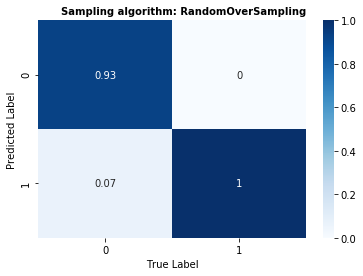

In [31]:
"""
    Output statistics - confusion matrix
"""

classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Sampling algorithm: ' + "RandomOverSampling", loc='right', fontsize=10, fontweight='bold')